# 地形段彩図の描画

GMTは`(x, y, z)` あるいは `(lon, lat, z)` のような3次元データとしてNetCDF形式のデータ（通称グリッドデータ）を読むことができ，`z`軸の値に応じて色を割り当てることができます．ここでは特に地図としてよく用いられる地形段彩図の描画とその応用を扱います．

まずは`pygmt`モジュールを読み込んでおきましょう．

In [7]:
import pygmt

GMTでは手持ちのNetCDF（`grd` or `nc`）ファイルを描画するのはもちろん，GMT6以降ではネットワーク越しにグローバルな地形データを取得するコマンドが提供されています．そこで，ここではその `pygmt` 版を用いて，地形図の描画を行ってましょう．

地形データを読み込むには以下のようにします．

In [21]:
grid_data = pygmt.datasets.load_earth_relief(
    resolution='01m',
    region = [128, 150, 28, 50]
)

grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: SRTM15 Earth Relief v2.7 at 01x01 arc minutes reduced by Gaussian Cartesian filtering (5.2 km fullwidth) [Tozer et al., 2019].
grdblend [NOTICE]:   -> Download 30x30 degree grid tile (earth_relief_01m_g): N00E120


上記のコマンドで，`region` で指定した地域の地形を `resolution` の解像度で読み込み，左辺の変数（`grid_data`）に格納します．この変数を用いてあとで地形図を作成します．

`region`の指定方法は地図と同じです．省略した場合には全世界のグローバルデータが読み込まれます．

`resolution`は `01d`, `30m`, `20m`, `15m`, `10m`, `06m`, `05m`, `04m`, `03m`, `02m`, `01m`, `30s`, `15s`, `03s`, `01s` から，つまり1秒角から1度までのうちからどれか一つを選びます．

ダウンロードされるデータはSRTM（Shuttle Rader Topography Mission）で，解像度によりデータソース（提供年）が異なるようです．また，1秒と3秒グリッドには海底地形データが存在しないため，15秒データから補間されます．ダウンロードしたデータは `~/.gmt/` 以下にキャッシュされます．あまり細かいグリッドで広域のデータを読み込むと，ダウンロードにもプロットにも時間がかかりますし，ディスクスペースも消費しますので，注意してください．

まずはこの地形図をほとんどそのまま可視化してみましょう．

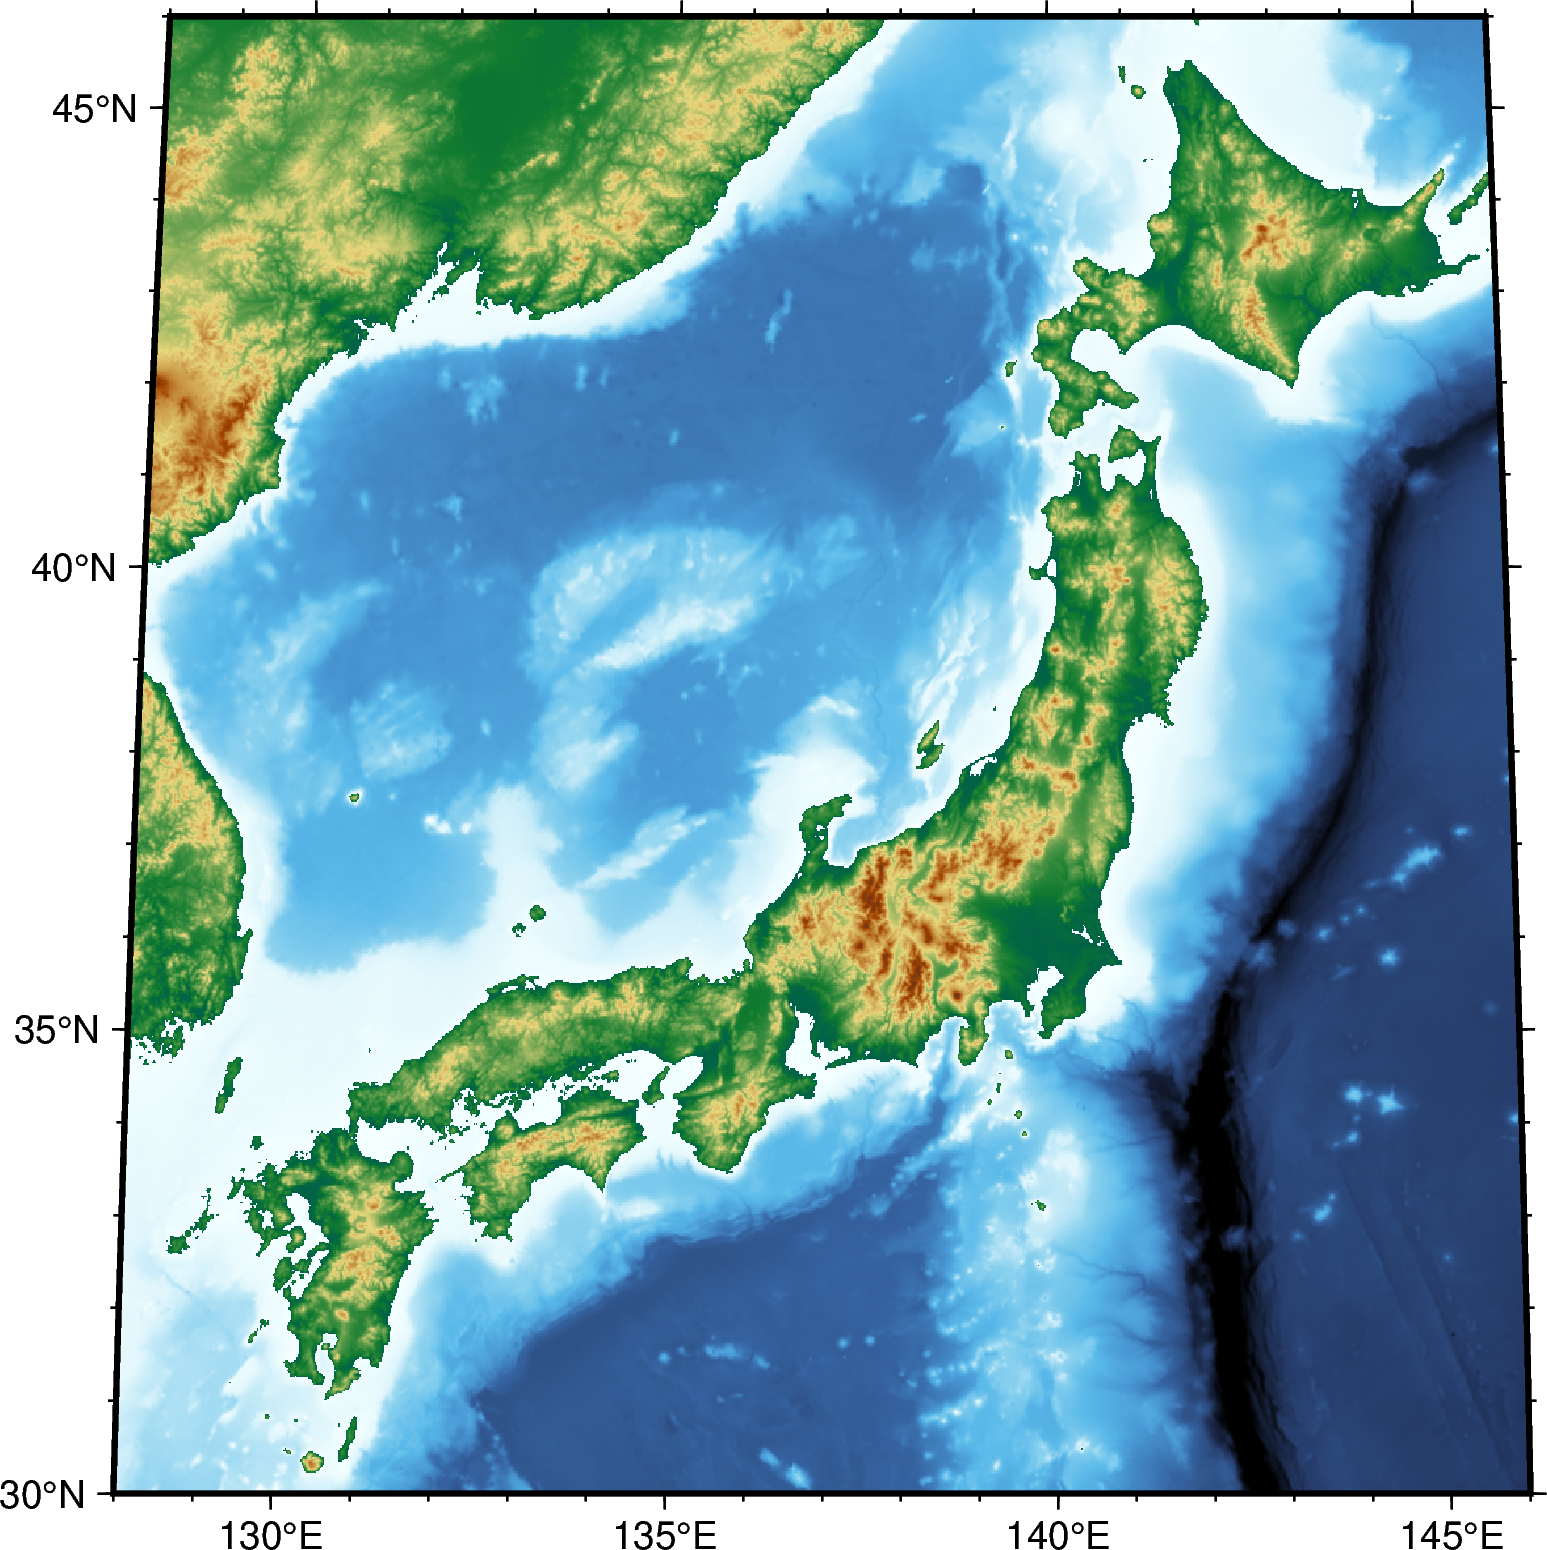

In [23]:
fig = pygmt.Figure()

# カラーマップ作成．以降ではこのCPTが自動的に使われる．
pygmt.makecpt(
    cmap = 'geo', 
)

# 標高と斜度データを可視化
fig.grdimage(
    projection = 'N138/12c', 
    region     = [128, 146, 30, 46], 
    grid       = grid_data,             # さきほど作成したデータを変数として渡す
    frame      = ['WSen', 'xaf', 'yaf']
)

fig.show()

これで色が付きました．海岸線を描画した代わりに `fig.grdimage` でさきほど作成した `grid_data` の値に応じて色を割り当てています．その値と色の対応テーブルを作成するのが `pygmt.makecpt` コマンドです．このコマンドではカラーマップのほか，値の範囲なども指定できます．ここでは，`geo`というカラーマップだけを指定し，値の範囲は省略してデフォルトの状態に任せています．

カラーマップの種類は[GMTのcookbook](https://docs.generic-mapping-tools.org/latest/cookbook/cpts.html#built-in-color-palette-tables-cpt)に記載されています．とても種類が多いですが，地形の描画に向いているのは`earth`, `geo`, `etopo1`, `globe`, `relief`, `terra`, `world`あたりです．ただし，このうち`terra`と`world`はデフォルトのカラーパレットの範囲が日本海溝の最も深い部分をうまく表現できないようで，範囲の調整が必要になりそうです．

```{tip}
GMTでは，cptファイルや地形のグリッドデータは，一旦ファイルに保存し，そのファイル名を `gmt grdimage` のオプションとして指定していました．それがPyGMTではグリッドデータについては変数で，cptファイルについては直前に生成したものが自動で，それぞれ読み込まれます．

これは単純な作図では記述量が減って便利ですが，特に複数のcptファイルを使う複雑な絵ではかえってやっかいかもしれません．ですが，引数`cmap`にはあらかじめ作成しておいたcptファイルの名前を指定することでも実行可能です．`grid`についても同様で，Python以外の環境で作成した既存のNetCDFファイル名を指定してそれを直接読み込み，可視化することができます．

```

## より凝った段彩図の描画

段彩図をより見栄え良くするには，`grdgradient`による傾斜データの作成と利用が有効です．

In [24]:
gradient_data = pygmt.grdgradient(
    grid      = grid_data,
    azimuth   = [45, 135], 
    normalize = 'e0.7'
)

GMTの `grdgradient` と同じですが，地形の可視化に用いる場合には方角 `azimuth` を複数方向の組み合わせにし，かつ `normalize` を上記の例程度の値にしておくのが良いようです．

```{admonition} ToDo
[Demo](https://www.pygmt.org/dev/gallery/images/grdgradient.html#sphx-glr-gallery-images-grdgradient-py)を見ると，`radiance`パラメータにより計算した`grd`データで地形可視化を行っている．要調査．
```

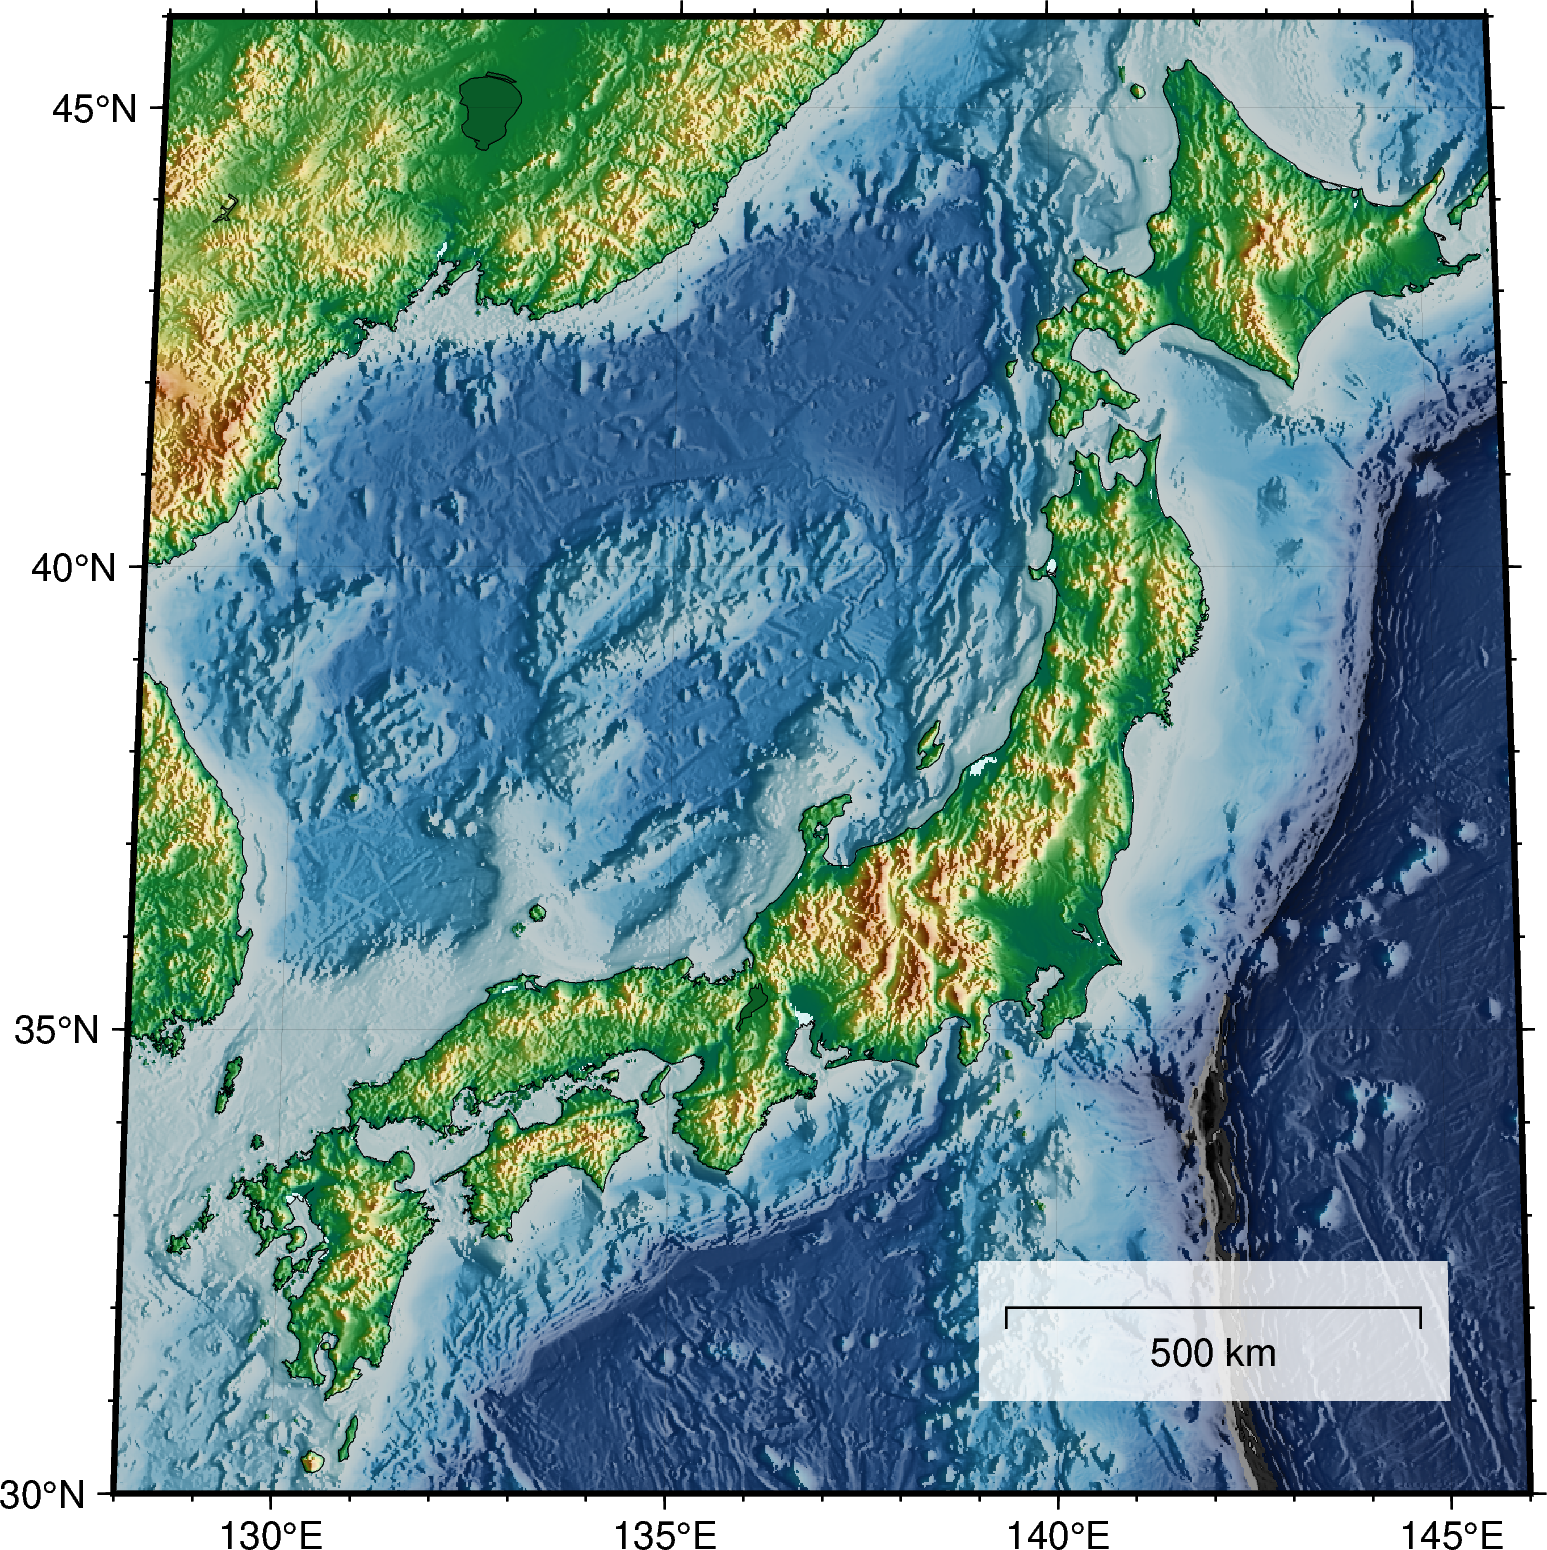

In [25]:
fig = pygmt.Figure()

# カラーマップ作成．以降ではこのCPTが自動的に使われる．
pygmt.makecpt(
    cmap = 'geo', 
)

# 標高と斜度データを可視化
fig.grdimage(
    projection = 'N138/12c', 
    region     = [128, 146, 30, 46], 
    grid       = grid_data, 
    shading    = gradient_data
)

# 海岸線描画と海域を半透明シェーディング
fig.coast(
    area_thresh = '100', 
    water       = 'black@80',
)

# 距離スケールの背景のための領域
fig.plot(
    data = [[139, 31], [145,31], [145,32.5], [139,32.5]], 
    fill = 'white',
    transparency = 20,
    straight_line = True    
)

# もう一度海岸線
fig.coast(
    area_thresh = '100', 
    map_scale   = '142/32/32/500',
    shorelines  = 'faint,black',
    frame       = ['WSen', 'xaf', 'yaf']
)
fig.show()

ここでは，見た目を向上させるテクニックを2つほど使っています．どちらもPyGMT以外の話題も含みますが，すこし詳しく解説しておきましょう．

まず，単に `fig.grdimage` で色を塗るだけでなく，その上に海岸線を描画しています．さらに，この例で用いた `earth` カラーパレットは陸域と海域の差が目立たなかったため，`fig.coast` の `water` で透明度80%の黒色（`black@80`）で海域を塗りつぶすことで，相対的に陸域が浮かび上がって見えるように工夫しています．色名のあとの`@`は透明度指定で，100に近いほど透明度が高くなります．`water = 'black@80` の行をコメントアウトして実行してみると，その差が実感できるでしょう．ただし，このテクニックを使うともとの色を改変することになりますので，カラースケールを表示してもその色が正確ではなくなりますので，注意が必要です．

一方，地図の距離スケール（`fig.pscoast`の`map-scale`オプション）をカラフルなカラーマップ上に描画すると，視認性がとても低くなってしまいます．そこで，`fig.plot()` で四角形の頂点を与え，半透明の白い「箱」を先に描画しています．これは順番が大事で，`fig.coast()`の**前**に予め箱を描画しておかないと，せっかくの地図スケールを塗りつぶしてしまうことになりかねません．`fig.plot()` には四隅の頂点を2次元配列として `data=` オプションに与えていますが，x軸とy軸の1次元配列を個別に `x = `, `y = ` として与えることもできます．なお，地図上に頂点を指定してポリゴンを描画すると，デフォルトではその辺が地図上の大円経路に沿った線として描画されます．結果として，地図投影上は曲がった線に見えてしまいます．これを避けているのが` straight_line = True` オプションです．


```{important}
`fig.plot()`のオプション `fill=` はその名のとおり塗りつぶしの色を指定するオプションですが，PyGMT v0.8.0 までは，このオプションは `color=` であったものが，オプション名の変更がなされたようです．しばらくの移行期間を経て，v0.12.0 以降では`color`オプションは動作しなくなりました．
```